# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
#Describe the number of times each user interacts with an article using the describe function for each email associated with an article
user_article=df['email'].value_counts()
user_article.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

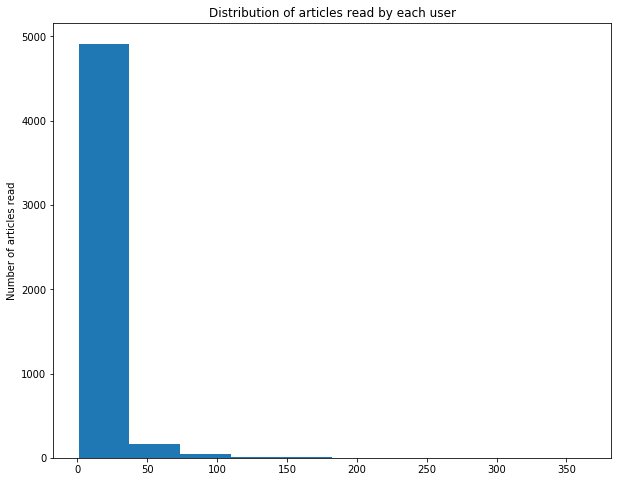

In [4]:
plt.figure(figsize=(10,8))
plt.hist(user_article) #normed=True, alpha=.5, label='actual');
plt.ylabel('Number of articles read');
plt.title('Distribution of articles read by each user');

In [5]:
# Fill in the median and maximum number of user_article interactios below
#The values were estimated from the descriptive analysis above
median_val = 3.0 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

In [6]:
# Find and explore duplicate articles
df_content[df_content[['article_id']].duplicated() == True]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', inplace=True)
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [8]:
#Retreive the values from the affected dataframes
a = df['article_id'].nunique()
b = df_content['article_id'].nunique()
c = df['email'].nunique()
d = df.shape[0]

a, b, c, d

(714, 1051, 5148, 45993)

In [9]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [10]:
#The most viewed article by email
most_viewed_article = df.groupby(['article_id']).count()['email'].sort_values(ascending=False)

most_viewed_article.head()

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: email, dtype: int64

In [11]:
most_viewed_article_id = '1429.0'    # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [12]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [13]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [14]:
n=5
df['title'].value_counts().sort_values(ascending=False)[:n].index.tolist()

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm']

In [15]:
df['article_id'].value_counts().sort_values(ascending=False)[:n,].index.tolist()

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0]

In [16]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Get the count of titles and sort the values in descending order
    #Filter the n number of items from the sorted dataframe
    top_articles = df['title'].value_counts().sort_values(ascending=False)[:n].index.tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Count the article id and sort in descending order
    #top_id = df['article_id'].value_counts().sort_values(ascending=False)
    
    #get top list of n number of ids
    top_articles = df['article_id'].value_counts().sort_values(ascending=False)[:n,].index.tolist()
 
    return top_articles # Return the top article ids

In [17]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [18]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [19]:
func = lambda x: x.max() #x.sum()

new_df = df[['user_id', 'article_id']]
new_df['interaction'] = 1
user_item = new_df.groupby(['user_id', 'article_id'])['interaction'].apply(func).unstack()
user_item.iloc[user_item.isnull()] = 0

In [20]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Remove duplicate and use pivot to reshape the dataframe 
    new_df = df.drop_duplicates()
    
    #create a pivot table to reshape to a matrix form
    try:
        #user_item = new_df.pivot(index='user_id', columns='article_id', values='title')
        new_df = df[['user_id', 'article_id']]
        #create a column with 1 value where an interaction exist in the new dataframe
        new_df['interaction'] = 1
        user_item = new_df.groupby(['user_id', 'article_id'])['interaction'].apply(lambda x: x.max()).unstack()
        
        #fill all NaN with 0
        user_item.iloc[user_item.isnull()] = 0  
    except:
        user_item = new_df.pivot(index='user_id', columns='article_id')
    
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [22]:
list(df.columns)

['article_id', 'title', 'user_id']

In [23]:
user_item.shape, user_item.sum(axis=1)[1]

((5149, 714), 36.0)

In [24]:
## Tests: Youuser_item.sum(axis=1)[1] should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [25]:
#user_idx = np.where(user_item['user_id'] == 1)[0][0]
user_content_matrix = user_item.dot(np.transpose(user_item))
current_user_content = user_content_matrix.loc[1, :]

In [26]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    
    #compute similarity of each user to the provided user
    #using the example in the class lesson - movie_content.dot(np.transpose(movie_content))
    #since the similarity is based on the dot product, calculate the dot product first
    user_content_matrix = user_item.dot(np.transpose(user_item))
    
    #select from the row of the current user to the last row and the all columns
    current_user_content = user_content_matrix.loc[user_id, :]
    
    # sort by similarity
    similar_user_content = current_user_content.sort_values(ascending=False)

    # create list of just the ids
    similar_users = list(similar_user_content[similar_user_content.values > 0].index)
   
    # remove the own user's id
    similar_users.remove(user_id)
    
    return similar_users # return a list of the users in order from most to least similar

In [27]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [28]:
article_ids=['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0']
list(set(df.query('article_id in @article_ids')['title']))

['using deep learning to reconstruct high-resolution audio',
 'gosales transactions for naive bayes model',
 'healthcare python streaming application demo',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'use r dataframes & ibm watson natural language understanding',
 'build a python app on the streaming analytics service']

In [29]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Create a list of article titles based on article_ids
    '''article_names = []
    for id in article_ids:
        title = df[df['article_id']]==id]['title'][0]
        article_names.append(title)'''
    #Change the article_id field to string irrespective of the data type
    df['article_id'] = df['article_id'].astype(str)
    article_names = list(set(df.query('article_id in @article_ids')['title']))
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Create a list of article ids and article names from the user position and all columns 
    user_data = user_item.loc[user_id, :]
    article_ids = list(set(user_data[user_data.values==1].index))
    article_ids = [str(id) for id in article_ids]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    #retreive users similar to the current user id using the function find_similar_users
    similar_users = find_similar_users(user_id)
    
    #get the article_ids seen by this user
    user_article_ids , _ = get_user_articles(user_id)
    
    #define an empty array
    recs = []
    #Loops through the users based on closeness to the input user_id
    for similar_user_id in similar_users:
        #For each user - finds article_ids the user hasn't seen before and provides them as recs
        article_ids, _ = get_user_articles(similar_user_id)
        #https://numpy.org/doc/stable/reference/generated/numpy.setdiff1d.html
        #not_seen_articles = list(set(article_names).difference(user_article_names))
        #using the above set function, 1D array of values in user_article_ids that are not in article_ids
        not_seen_article_ids = np.setdiff1d(user_article_ids, article_ids) #list(set(user_article_ids).difference(article_ids)) # n
        
        if len(not_seen_article_ids) > 0:
            recs.extend(not_seen_article_ids)
            #remove duplicates
            recs = list(dict.fromkeys(recs))
            
        #Check if we have the required recommendations
        if len(recs) >= m:
            break
    
    #return only m number of recommendation
    return recs[:m] # return your recommendations for this user_id    

In [30]:
# Check Results
#user_user_recs(1, 10)
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['categorize urban density',
 'introduction to market basket analysis in\xa0python',
 'predict loan applicant behavior with tensorflow neural networking',
 'sector correlations shiny app',
 'uci: iris',
 'uci ml repository: chronic kidney disease data set',
 'fighting gerrymandering: using data science to draw fairer congressional districts',
 'country statistics: life expectancy at birth',
 'jupyter notebook tutorial',
 'time series prediction using recurrent neural networks (lstms)']

In [31]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [32]:
user_content_matrix = user_item.dot(np.transpose(user_item))
current_user_content = user_content_matrix.loc[131, :]

In [33]:
similarity_df = pd.DataFrame(current_user_content[current_user_content.values>0])
similarity_df.reset_index(level=0, inplace=True)
similarity_df.rename(columns={131: "similarity"}, inplace=True)
similarity_df = similarity_df.sort_values(['similarity'], ascending=False)
similarity_df.head(10)

,user_id,similarity
116,131,75.0
2576,3870,74.0
2523,3782,39.0
22,23,38.0
177,203,33.0
2940,4459,33.0
2474,3697,29.0
2515,3764,29.0
90,98,29.0
46,49,29.0


In [34]:
interaction_df = pd.DataFrame(df.groupby('user_id')['article_id'].count())
interaction_df.reset_index(level=0, inplace=True)
interaction_df.rename(columns = {'article_id': 'num_interactions'}, inplace=True)
interaction_df = interaction_df.sort_values(['num_interactions'], ascending=False)
interaction_df.head(10)

,user_id,num_interactions
22,23,364
3781,3782,363
97,98,170
3763,3764,169
202,203,160
4458,4459,158
241,242,148
48,49,147
3909,3910,147
3696,3697,145


In [35]:
#neighbors_df = pd.concat([similarity_df, interaction_df], axis=1, join="inner")
neighbors_df = pd.merge(similarity_df, interaction_df, on=["user_id"])
neighbors_df = neighbors_df.rename(columns={'user_id':'neighbor_id'})
neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != 131].sort_values(['similarity', 'num_interactions'], ascending=[False, False])

list(neighbors_df['neighbor_id'])

neighbors_df.head(18)
#len(close_user_ids)

,neighbor_id,similarity,num_interactions
1,3870,74.0,144
2,3782,39.0,363
3,23,38.0,364
4,203,33.0,160
5,4459,33.0,158
8,98,29.0,170
7,3764,29.0,169
9,49,29.0,147
6,3697,29.0,145
11,242,25.0,148


In [36]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    #Create a similarity dataframe
    #To create the neighbour_df, i decided to create two separate dataframes inheriting some codes from find_similar_users
    user_content_matrix = user_item.dot(np.transpose(user_item))
    current_user_content = user_content_matrix.loc[user_id, :]
    
    # Create a similarity dataframe based on current_user_content
    similarity_df = pd.DataFrame(current_user_content[current_user_content.values > 0])
    similarity_df.reset_index(level=0, inplace=True)
    similarity_df.rename(columns={user_id: "similarity"}, inplace=True)
    
    #create user article interactions
    interaction_df = pd.DataFrame(df.groupby(by='user_id')['article_id'].count())
    interaction_df.reset_index(level=0, inplace=True)
    interaction_df.rename(columns = {'article_id': 'num_interactions'}, inplace=True)
    
    #Create the neighbour_df by concatenating the two datasets
    neighbors_df = pd.merge(similarity_df, interaction_df, on=["user_id"])
    
    
    neighbors_df = neighbors_df[neighbors_df['user_id'] != user_id]
    neighbors_df = neighbors_df.rename(columns={'user_id':'neighbor_id'})
    #sort the new dataframe by similarity and then by number of interactions 
    neighbors_df = neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=[False, False])

    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    #
    #retreive users close to the current user id using the function get_top_sorted_users
    neighbors_df = get_top_sorted_users(user_id)
    neighbor_ids = list(neighbors_df.sort_values(['num_interactions','similarity'], ascending=[False, False])['neighbor_id'])
    #get the article_ids seen by this user
    user_article_ids , _ = get_user_articles(user_id)
    
    #define an empty array
    recs = []
    #Loops through the users based on closeness to the input user_id
    for neighbor_id in neighbor_ids:
        #For each user - finds article_ids the user hasn't seen before and provides them as recs
        article_ids, _ = get_user_articles(neighbor_id)
        #https://numpy.org/doc/stable/reference/generated/numpy.setdiff1d.html
        not_seen_article_ids = np.setdiff1d(article_ids, user_article_ids)
        
        if len(not_seen_article_ids) > 0:
            recs.extend(not_seen_article_ids)
            #remove duplicates
            recs = list(dict.fromkeys(recs))
            
        #Check if we have the required recommendations
        if len(recs) >= m:
            break
    
    #get the rec_names using the function get_article_names
    rec_names = get_article_names(recs)
    
    return recs[:m], rec_names[:m]

In [37]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['101.0', '1018.0', '1024.0', '1025.0', '1047.0', '1048.0', '1054.0', '108.0', '110.0', '1116.0']

The top 10 recommendations for user 20 are the following article names:
['working interactively with rstudio and notebooks in dsx', 'analyze precipitation data', 'modern machine learning algorithms', 'predicting churn with the spss random tree algorithm', 'this week in data science (may 23, 2017)', 'real-time sentiment analysis of twitter hashtags with spark (+ pixiedust)', 'developing for the ibm streaming analytics service', 'apache spark lab, part 3: machine learning', '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object', 'markdown for jupyter notebooks cheatsheet']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [38]:
get_top_sorted_users(1).iloc[0], get_top_sorted_users(131).iloc[9]

(neighbor_id         3933.0
 similarity            35.0
 num_interactions      45.0
 Name: 1883, dtype: float64, neighbor_id         242.0
 similarity           25.0
 num_interactions    148.0
 Name: 211, dtype: float64)

In [39]:
get_top_sorted_users(131).iloc[0:18]

,neighbor_id,similarity,num_interactions
2576,3870,74.0,144
2523,3782,39.0,363
22,23,38.0,364
177,203,33.0,160
2940,4459,33.0,158
90,98,29.0,170
2515,3764,29.0,169
46,49,29.0,147
2474,3697,29.0,145
211,242,25.0,148


In [40]:
### Tests with a dictionary of results
user1_most_sim = list(get_top_sorted_users(1)['neighbor_id'])[0] # find_similar_users(1)[0] # Find the user that is most similar to user 1 
user131_10th_sim = list(get_top_sorted_users(131)['neighbor_id'])[9] #find_similar_users(131)[9] # Find the 10th most similar user to user 131

In [41]:
user1_most_sim, user131_10th_sim

(3933, 242)

In [42]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**
#### A new user in this case does not have any observed scores, hence the get_top_article_ids function can be used to make recommendations, which could be a temporarity solution to cater for this recommendation. Kindly note that user_user_recs_part2 requires an existing user data, hence it is not recommended for this use case.

#### A better ways to make these recommendations where new users are involved would be to combine Knowledge or rank based and Content based recommendations with FunkSVD.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [43]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to
#list_of_ids = get_top_article_ids(10)
#list_of_ids
new_user_recs = get_top_article_ids(10)

In [44]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [45]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [46]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [47]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

In [48]:
vt

array([[ -2.21822365e-03,  -1.13697491e-03,  -8.25820256e-03, ...,
         -7.89214713e-03,  -2.78398235e-02,  -3.49679488e-04],
       [  2.07736845e-03,   3.86642452e-04,   1.51981454e-03, ...,
         -1.56120895e-02,   9.70825293e-04,  -4.30034249e-04],
       [ -4.32111291e-04,   2.46676561e-03,   4.28288891e-03, ...,
          1.20613591e-02,   1.21832171e-02,   1.08416259e-03],
       ..., 
       [  0.00000000e+00,   3.15631941e-16,   1.84475856e-16, ...,
          5.48706963e-17,   9.44710455e-17,   1.23662293e-16],
       [  0.00000000e+00,  -2.38531913e-16,   2.65894675e-18, ...,
          1.71338757e-16,   7.09063975e-17,  -1.89755859e-16],
       [  0.00000000e+00,   2.26402240e-17,   3.39637767e-16, ...,
         -7.85447059e-17,  -6.56620070e-17,  -9.63564231e-17]])

**MY RESPONSE:**
#### FunkSVD is an improvement of the standard SVD because it carters for Null or non exsiting values (NaN). The difference between the data used in our lesson and that used in this exercise is that the lesson data comprised of user rating data and where rating did not exist, NaN values substituted for them. In this case the user_item_matrix is composed of ones and zeros and NaN values are absent from it. That was why SVD is prefarred for use

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

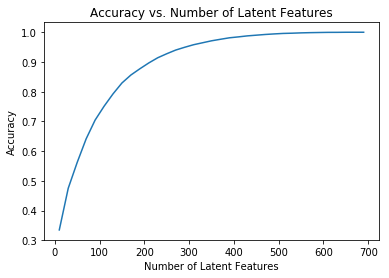

In [49]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [50]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    #create a user item matrix using the previous function create_user_item_matrix
    #a user-item matrix of the training dataframe 
    user_item_train = create_user_item_matrix(df_train)
    #a user-item matrix of the testing dataframe
    user_item_test = create_user_item_matrix(df_test)
    
    train_idx = user_item_train.index.values 
    train_arts = user_item_train.columns.values 
    
    #all of the test user ids
    test_idx = user_item_test.index.values  
    #all of the test article ids
    test_arts = user_item_test.columns.values 
    
    common_idx = [s for s in train_idx if s in test_idx]
    common_arts = [s for s in train_arts if s in test_arts]
    
    user_item_test = user_item_test.loc[common_idx, common_arts]
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [51]:
user_item_train.shape, user_item_test.shape, len(test_idx), len(test_arts)


((4487, 714), (20, 574), 682, 574)

In [52]:
# find the common users in both test and train dataset
print(user_item_train.index.isin(test_idx).sum())
# total number of user in test set
print(len(test_idx))
print(len(test_idx) - user_item_train.index.isin(test_idx).sum())
# find the common articles in both test and train set
print(user_item_train.columns.isin(test_arts).sum())
# How many articles in the test set are we not able to make predictions for because of the cold start problem?
print(len(test_arts) - len([s for x in list(set(user_item_train.columns.values)) if x in test_arts]))

20
682
662
574
0


In [53]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [54]:
# fit SVD on the user_item_train matrix 
#using https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [55]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [56]:
user_item_train.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
#Now use the user_item_train dataset from above to find U, S, and V transpose using SVD. 

#  get users in train set available in the test set
user_idx = user_item_train.index.isin(test_idx)

#get the articles in train set available in test set
arts_idx = user_item_train.columns.isin(test_arts)

#use the common data (idx and articles to get the matrix for the test set)
u_test = u_train[user_idx, :]
vt_test = vt_train[:, arts_idx]

In [58]:
latent_feats = np.arange(10, 700+10, 20)

sum_errs = []


for k in latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]

    # take dot product
    user_item_test_predicted = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))

    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test, user_item_test_predicted)

    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)


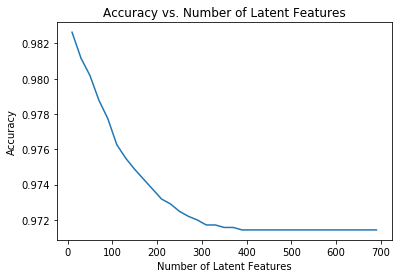

In [59]:
no_of_interactions = user_item_test.shape[0] * user_item_train.shape[1] 
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/no_of_interactions);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**My Response.**
#### In the first graph, you would notice that as the latent features increased, there was a corresponding increase in the accurracy of the result but in the graph above, the reverse is the case. The currect graph shows a drastic decrease in the accuracy as the latent features increases. You can also attribute this reduction to the size of data in the test set which may not be a sufficient sample size that could be used to draw conclusions and make accurate recommendations.

#### Hence due to the above, it would be proper to employ A/B Testing in order to use data from a randomize experiment from two or more sources and measure the maximum impact, drive business metrics and reduce guesswork. Because this experiment was based on a single source of data taken from different points (top and button), hence the test set was probably guessed which A/B Testing would have eliminated.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [60]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0